In [1801]:
# import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [1802]:
cwd = os.getcwd()
data_file_name = "/dataset/day.csv"
dataset = pd.read_csv(cwd + data_file_name)
dataset.shape #(731, 16)

(731, 16)

In [1803]:
dataset[710:]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
710,711,2012-12-11,4,1,12,0,2,1,2,0.353333,0.338363,0.596667,0.296037,282,5219,5501
711,712,2012-12-12,4,1,12,0,3,1,2,0.297500,0.297338,0.538333,0.162937,310,5009,5319
712,713,2012-12-13,4,1,12,0,4,1,1,0.295833,0.294188,0.485833,0.174129,425,5107,5532
713,714,2012-12-14,4,1,12,0,5,1,1,0.281667,0.294192,0.642917,0.131229,429,5182,5611
714,715,2012-12-15,4,1,12,0,6,0,1,0.324167,0.338383,0.650417,0.106350,767,4280,5047
715,716,2012-12-16,4,1,12,0,0,0,2,0.362500,0.369938,0.838750,0.100742,538,3248,3786
716,717,2012-12-17,4,1,12,0,1,1,2,0.393333,0.401500,0.907083,0.098258,212,4373,4585
717,718,2012-12-18,4,1,12,0,2,1,1,0.410833,0.409708,0.666250,0.221404,433,5124,5557
718,719,2012-12-19,4,1,12,0,3,1,1,0.332500,0.342162,0.625417,0.184092,333,4934,5267
719,720,2012-12-20,4,1,12,0,4,1,2,0.330000,0.335217,0.667917,0.132463,314,3814,4128


In [1804]:
# convert string to datetime
dataset.dteday = dataset.dteday.apply(lambda x:pd.to_datetime(x))
dataset = dataset.drop(['instant'], axis = 1)
dataset = dataset.rename(columns={'registered': 'regist'})
dataset[dataset.dteday == '2012-10-29'].index
dataset = dataset.drop(dataset[dataset.dteday == '2012-10-29'].index)


In [1805]:
# calculate the ahead n-7 to n-2 days average number
def calcAvgShift(dfCol, period, exclude):
    try:
        summary = dfCol.rolling(period).mean()
        if period is None:
            return dfCol
        if exclude is None:
            return summary
        mean = dfCol.shift(exclude).rolling(period, 1).mean()
        return mean.apply(lambda x: round(x, 3))
    except Exception as e:
        print("error:" + str(e))

In [1806]:
def calcIncreaseRatio(pre, comp):
    inc = (comp - pre) / pre
    return round(inc, 3)

In [1807]:
dataset['casual_lag2'] = dataset['casual'].shift(2)
dataset['regist_lag2'] = dataset['regist'].shift(2)
dataset['cnt_lag2'] = dataset['cnt'].shift(2)

dataset['temp_inc'] = calcIncreaseRatio(dataset.temp.shift(1), dataset.temp)
# dataset['temp_inc2day'] = calcIncreaseRatio(dataset.temp.shift(2), dataset.temp.shift(1))
# dataset['hum_inc2day'] = calcIncreaseRatio(dataset.hum.shift(2), dataset.hum.shift(1))

# dataset['casual_avg_aheadWeek'] = calcAvgShift(dataset.casual, 7, 2)
# dataset['regist_avg_aheadWeek'] = calcAvgShift(dataset.regist, 7, 2)
# dataset['cnt_avg_aheadWeek'] = calcAvgShift(dataset.cnt, 7, 2)

dataset['casual_avg_ahead3days'] = calcAvgShift(dataset.casual, 5, 2)
dataset['regist_avg_ahead3days'] = calcAvgShift(dataset.regist, 5, 2)
dataset['cnt_avg_ahead3days'] = calcAvgShift(dataset.cnt, 5, 2)

dataset['casual_avg_aheadMonth'] = calcAvgShift(dataset.casual, 31, 2)
dataset['regist_avg_aheadMonth'] = calcAvgShift(dataset.regist, 31, 2)
dataset['cnt_avg_aheadMonth'] = calcAvgShift(dataset.cnt, 31, 2)

dataset['casual_median_LastWeek'] = dataset.casual.shift(2).rolling(7, 1).median()
dataset['regist_median_LastWeek'] = dataset.regist.shift(2).rolling(7, 1).median()
dataset['cnt_median_LastWeek'] = dataset.cnt.shift(2).rolling(7, 1).median()

dataset['casual_max_LastWeek'] = dataset.casual.shift(2).rolling(7, 1).max()
dataset['regist_max_LastWeek'] = dataset.regist.shift(2).rolling(7, 1).max()
dataset['cnt_max_LastWeek'] = dataset.cnt.shift(2).rolling(7, 1).max()

dataset['casual_inc_ratio_monthly'] = calcIncreaseRatio(calcAvgShift(dataset.casual, 31, 2), dataset.casual_lag2)
dataset['regist_inc_ratio_monthly'] = calcIncreaseRatio(calcAvgShift(dataset.regist, 31, 2), dataset.regist_lag2)
dataset['cnt_inc_ratio_monthly'] = calcIncreaseRatio(calcAvgShift(dataset.cnt, 31, 2), dataset.cnt_lag2)

dataset['casual_inc_ratio_weekly'] = calcIncreaseRatio(calcAvgShift(dataset.casual, 7, 2), dataset.casual_lag2)
dataset['regist_inc_ratio_weekly'] = calcIncreaseRatio(calcAvgShift(dataset.regist, 7, 2), dataset.regist_lag2)
dataset['cnt_inc_ratio_weekly'] = calcIncreaseRatio(calcAvgShift(dataset.cnt, 7, 2), dataset.cnt_lag2)

dataset['casual_lastWeekday'] = dataset.casual.shift(7)
dataset['regist_lastWeekday'] = dataset.regist.shift(7)
dataset['cnt_lastWeekday'] = dataset.cnt.shift(7)

dataset['casual_inc_ratio'] = ((dataset['casual'] - dataset['casual_lag2']) / dataset['casual_lag2']).apply(lambda x:round(x, 3))
dataset['regist_inc_ratio'] = ((dataset['regist'] - dataset['regist_lag2']) / dataset['regist_lag2']).apply(lambda x:round(x, 3))
dataset['cnt_inc_ratio'] = ((dataset['cnt'] - dataset['cnt_lag2']) / dataset['cnt_lag2']).apply(lambda x:round(x, 3))

dataset.to_csv("./totalBikeSharing.csv", index=False)




In [1808]:
# one hot encode dummy encode
dummy_season = pd.get_dummies(dataset.season, prefix="season")
dummy_weathersit = pd.get_dummies(dataset.weathersit, prefix="weathersit")
# dummy_weekday = pd.get_dummies(dataset.weekday, prefix="weekday")
dataset = pd.concat([dataset, dummy_season, dummy_weathersit], axis = 1)

In [1809]:
# drop columns and mark some columns
casual_cols = dataset.filter(like = 'casual').columns.values.tolist() # filter the column name contain casual
regist_cols = dataset.filter(like = 'regist').columns.values.tolist()
cnt_cols = dataset.filter(like = 'cnt').columns.values.tolist()

oneHotCols = dataset.filter(regex='workingday|holiday|weekday|weathersit_|season_').columns.values
exclude_dict = {'casual': regist_cols + cnt_cols, 'regist': casual_cols + cnt_cols, 'cnt': casual_cols + regist_cols}


In [1810]:
# split train and test
target = 'cnt'
target_col_name = target + '_inc_ratio'

train = dataset[dataset.dteday < datetime(2012, 1, 1)]
test = dataset[dataset.dteday > datetime(2011, 12, 31)]

train_Y_origin = train[target]
test_Y_origin = test[target]

train_Y = train[target_col_name]
test_Y = test[target_col_name]

drop_col = ['dteday', 'yr', 'mnth', 'weekday', 'season', 'weathersit', 'cnt', 'atemp'
           ]
drop_col.extend([target_col_name, target])

drop_col.extend(list(exclude_dict[target]))

train_X = train.drop(drop_col, axis = 1)
test_X = test.drop(drop_col, axis = 1)
standCols = [i for i in train_X.columns.values if i not in oneHotCols]
standCols

['temp',
 'hum',
 'windspeed',
 'cnt_lag2',
 'temp_inc',
 'cnt_avg_ahead3days',
 'cnt_avg_aheadMonth',
 'cnt_median_LastWeek',
 'cnt_max_LastWeek',
 'cnt_inc_ratio_monthly',
 'cnt_inc_ratio_weekly',
 'cnt_lastWeekday']

In [1811]:
train_X = train_X[7:] # remove the begining 7 NaN
train_Y = train_Y[7:]


In [1839]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_X[standCols])
train_X.loc[:, standCols] = scaler.transform(train_X[standCols])
test_X.loc[:, standCols] = scaler.transform(test_X[standCols])
train_X

,holiday,workingday,temp,hum,windspeed,cnt_lag2,temp_inc,cnt_avg_ahead3days,cnt_avg_aheadMonth,cnt_median_LastWeek,...,cnt_inc_ratio_monthly,cnt_inc_ratio_weekly,cnt_lastWeekday,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
7,0,0,-1.736536,-0.735774,0.974136,-1.343224,-1.033120,-1.667095,-1.699775,-1.675329,...,0.725079,0.971262,-1.788059,1,0,0,0,0,1,0
8,0,0,-1.878437,-1.420220,2.206879,-1.413556,-1.044854,-1.551932,-1.677145,-1.631611,...,0.351372,0.535959,-1.922357,1,0,0,0,1,0,0
9,0,1,-1.811922,-1.092021,0.410057,-1.817231,0.433612,-1.615280,-1.716752,-1.631611,...,-1.139562,-1.314078,-1.522384,1,0,0,0,1,0,0
10,0,1,-1.714767,0.277646,-0.900281,-1.917600,0.615487,-1.735478,-1.760063,-1.631611,...,-1.447092,-1.781121,-1.366920,1,0,0,0,0,1,0
11,0,1,-1.695420,-0.306846,1.464183,-1.552022,0.034661,-1.780796,-1.753720,-1.631611,...,0.090556,-0.085254,-1.339184,1,0,0,0,1,0,0
12,0,1,-1.736536,-1.176174,1.417191,-1.594514,-0.358423,-1.836510,-1.752861,-1.783222,...,-0.096297,-0.139667,-1.334805,1,0,0,0,1,0,0
13,0,1,-1.758513,-0.722357,-0.843066,-1.668509,-0.241085,-1.893036,-1.759060,-1.829748,...,-0.388256,-0.289303,-1.404873,1,0,0,0,1,0,0
14,0,0,-1.372923,-0.985428,-0.436043,-1.489749,2.545706,-1.820430,-1.748885,-1.829748,...,0.331908,0.730938,-1.807036,1,0,0,0,0,1,0
15,0,0,-1.381788,-1.086413,-0.041264,-1.478759,-0.135480,-1.723134,-1.739285,-1.829748,...,0.339694,0.844298,-1.907029,1,0,0,0,1,0,0
16,1,0,-1.678892,-0.724552,0.031085,-1.605503,-1.508341,-1.734991,-1.740439,-1.829748,...,-0.189724,0.028106,-1.542820,1,0,0,0,0,1,0


array([False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False])

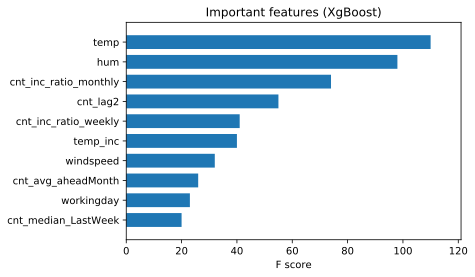

In [1813]:

from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance, plot_tree, to_graphviz

regr = XGBRegressor()
regr.fit(train_X, train_Y)

regr.feature_importances_
plot_importance(regr, max_num_features=10,  height=0.7,
                    title = 'Important features (XgBoost)',
                   grid = False, ylabel="", show_values=False)
regr.feature_importances_ > 0.03

In [1814]:
# selected_features = list(train_X.columns[regr.feature_importances_ > 0.03])
# train_X = train_X[selected_features]
# train_X
# test_X = test_X[selected_features]

In [1830]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dropout
from keras import regularizers

EPOCHS = 100
BATCH_SIZE = 20


model = Sequential()
model.add(Dense(train_X.shape[1], input_dim = train_X.shape[1], 
                kernel_initializer='random_uniform', 
                bias_initializer='ones',
                activation='relu'))
model.add(Dropout(0.25))
# model.add(Dense(train_X.shape[1], kernel_initializer='random_uniform',
#                 bias_initializer='ones',
#                 activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(7, kernel_initializer='random_uniform',
                bias_initializer='ones',
                activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_Y, epochs=EPOCHS, validation_data=(test_X, test_Y), batch_size=BATCH_SIZE, verbose = 2)
train_Y_prediction = model.predict(train_X)
test_Y_prediction = model.predict(test_X)
model.summary()


Train on 358 samples, validate on 365 samples
Epoch 1/100
 - 5s - loss: 0.3298 - val_loss: 0.3066
Epoch 2/100
 - 0s - loss: 0.3275 - val_loss: 0.3044
Epoch 3/100
 - 0s - loss: 0.3235 - val_loss: 0.2989
Epoch 4/100
 - 0s - loss: 0.3153 - val_loss: 0.2901
Epoch 5/100
 - 0s - loss: 0.3018 - val_loss: 0.2755
Epoch 6/100
 - 0s - loss: 0.2754 - val_loss: 0.2587
Epoch 7/100
 - 0s - loss: 0.2474 - val_loss: 0.2379
Epoch 8/100
 - 0s - loss: 0.2033 - val_loss: 0.2094
Epoch 9/100
 - 0s - loss: 0.1932 - val_loss: 0.1971
Epoch 10/100
 - 0s - loss: 0.1992 - val_loss: 0.2006
Epoch 11/100
 - 0s - loss: 0.1844 - val_loss: 0.1995
Epoch 12/100
 - 0s - loss: 0.1502 - val_loss: 0.1825
Epoch 13/100
 - 0s - loss: 0.1636 - val_loss: 0.1908
Epoch 14/100
 - 0s - loss: 0.1452 - val_loss: 0.1812
Epoch 15/100
 - 0s - loss: 0.1488 - val_loss: 0.1813
Epoch 16/100
 - 0s - loss: 0.1378 - val_loss: 0.1735
Epoch 17/100
 - 0s - loss: 0.1464 - val_loss: 0.1779
Epoch 18/100
 - 0s - loss: 0.1535 - val_loss: 0.1713
Epoch 19/

In [1831]:
lagColumnName = target + '_lag2'
predRationColumnName = target + '_pred_ratio'
predValueColumnName = target + '_pred_value'
test[predRationColumnName] = test_Y_prediction.flatten()
test[predValueColumnName] = test[lagColumnName] * ( 1 + test[predRationColumnName])


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


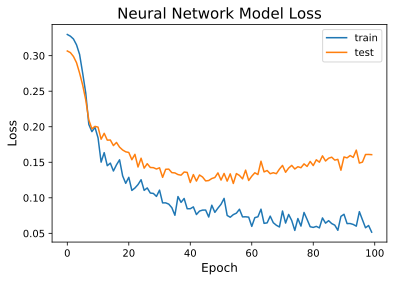

In [1833]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network Model Loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.savefig('training_NN.pdf', bbox_inches='tight')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

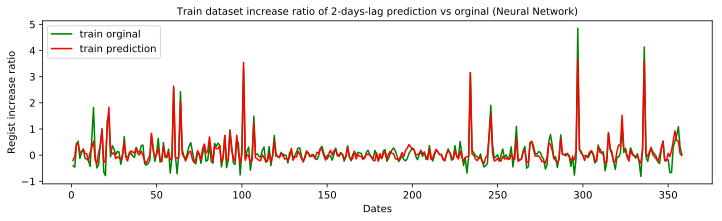

In [1834]:
result_train = pd.DataFrame({'train_Y':train_Y, \
              'pred_train_Y':train_Y_prediction.flatten()
             })
time = [x + 1 for x in range(0, result_train.shape[0])]


# pd.DataFrame({'train_Y': train_Y,\
#               'pred_train_Y': train_Y_prediction.flatten()
#              })
plt.figure(figsize=(12,3))
plt.plot(time, result_train.train_Y, color='green', label='train orginal')
plt.plot(time, result_train.pred_train_Y, color='red', label='train prediction')
plt.ylabel('Regist increase ratio', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.title('Train dataset increase ratio of 2-days-lag prediction vs orginal (Neural Network)', fontsize = 10)
plt.savefig('train_increase_ratio_origin_vs_prediction.pdf', bbox_inches='tight')
plt.legend(loc='upper left')
axes = plt.gca()
# axes.set_ylim([-1,5])
plt.show()

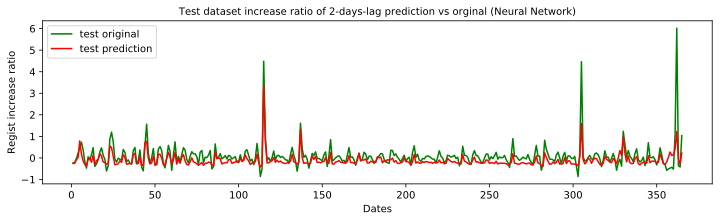

In [1835]:
# test_Y_prediction.flatten()



result = pd.DataFrame({'test_Y':test_Y, \
              'pred_test_Y':test_Y_prediction.flatten()
             })

time = [x + 1 for x in range(0, result.shape[0])]


# pd.DataFrame({'train_Y': train_Y,\
#               'pred_train_Y': train_Y_prediction.flatten()
#              })
plt.figure(figsize=(12,3))
plt.plot(time, result.test_Y, color='green', label='test original')
plt.plot(time, result.pred_test_Y, color='red', label='test prediction')
# plt.plot(time, [0 for i in range(0, result.shape[0])], '--')
plt.ylabel('Regist increase ratio', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.legend(loc='upper left')
plt.title('Test dataset increase ratio of 2-days-lag prediction vs orginal (Neural Network)', fontsize = 10)
plt.savefig('test_increase_ratio_origin_vs_prediction.pdf', bbox_inches='tight')
axes = plt.gca()
# axes.set_ylim([-1,5])
plt.show()

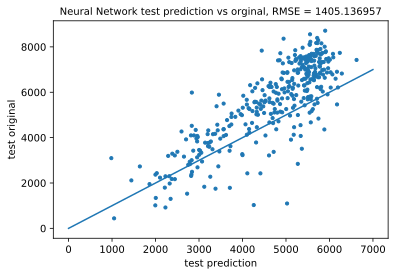

1405.1369569680562

In [1836]:
# test['prediction_value']
# test['regist']
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.figure()
ax = plt.scatter(test[predValueColumnName], test[target], s = 10)
plt.plot([x for x in range(0,7000)], [x for x in range(0, 7000)])
plt.ylabel('test original', fontsize = 10)
plt.xlabel('test prediction', fontsize = 10)
mse_NN = mean_squared_error(test[predValueColumnName], test[target])
mse = mse_NN**(0.5)
plt.title('Neural Network test prediction vs orginal, RMSE = %f'%mse, fontsize = 10)

plt.savefig('test_origin_vs_prediction.pdf', bbox_inches='tight')

plt.show()
mse_NN**(0.5)

In [1837]:
revenuePerBike = 3
loanCostPerBike = 2
profit = pd.DataFrame({predValueColumnName:test[predValueColumnName], \
              target:test[target]
             })
profit['revenue_daily'] = profit.apply(lambda x: revenuePerBike * min(x[target], x[predValueColumnName]), axis = 1)
profit['cost_daily'] = profit.apply(lambda x:x[predValueColumnName] * loanCostPerBike, axis = 1)
profit['profit_daily'] = profit.revenue_daily - profit.cost_daily
profit['test_lag2'] = test[lagColumnName]
profit['benchmark_profit'] = profit.apply(
    lambda x: (min(x['test_lag2'], x[target]) * revenuePerBike - loanCostPerBike * x['test_lag2']),
    axis = 1
) 
totalProfit = profit.profit_daily.sum()

profit.to_csv("./nn_profit_regist.csv", index=False)
totalProfit
# profit.benchmark_profit.sum()


1564936.8569244742

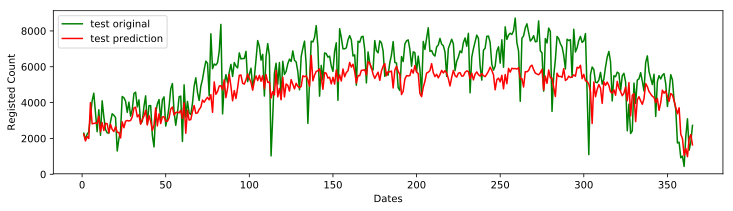

In [1838]:
time = [x + 1 for x in range(0, result.shape[0])]
plt.figure(figsize=(12,3))
plt.plot(time, profit[target], color='green', label='test original')
plt.plot(time, profit[predValueColumnName], color='red', label='test prediction')
# plt.plot(time, [0 for i in range(0, result.shape[0])], '--')
plt.ylabel('Registed Count', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.legend(loc='upper left')
axes = plt.gca()
# axes.set_ylim([-1,5])
plt.savefig('test_origin_vs_prediction_timeline.pdf', bbox_inches='tight')
plt.show()

In [1815]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [1816]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           learning_rate=0.09, 
                           gamma=0.1,
                           subsample=0.6,
                           colsample_bytree=0.9, 
                           max_depth=8,
                           alpha=1,
                           reg_lambda = 9
                          )
xgb.fit(train_X,train_Y)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.1, learning_rate=0.09,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=9, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [1817]:
predictions = xgb.predict(test_X)


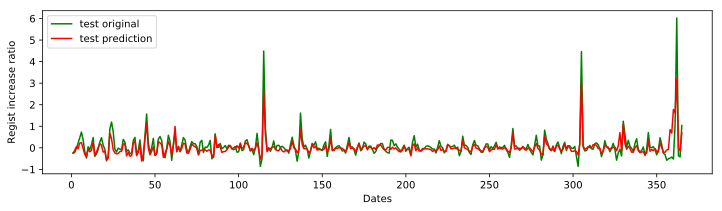

In [1818]:
time = [x + 1 for x in range(0, predictions.shape[0])]
plt.figure(figsize=(12,3))
plt.plot(time, test_Y, color='green', label='test original')
plt.plot(time, predictions, color='red', label='test prediction')
# plt.plot(time, [0 for i in range(0, result.shape[0])], '--')
plt.ylabel('Regist increase ratio', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.legend(loc='upper left')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Neural Network test prediction vs orginal, RMSE = 938.732415')

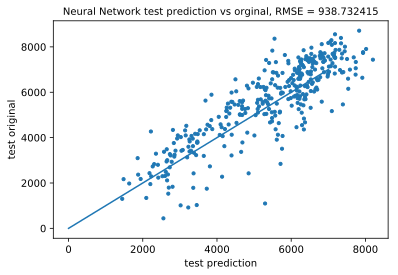

In [1819]:
test['xgb'] = test[lagColumnName] * ( 1 + predictions)

test

plt.figure()
ax = plt.scatter(test['xgb'], test[target], s = 10)
plt.plot([x for x in range(0,7000)], [x for x in range(0, 7000)])
plt.ylabel('test original', fontsize = 10)
plt.xlabel('test prediction', fontsize = 10)
mse_NN = mean_squared_error(test['xgb'], test[target])
mse = mse_NN**(0.5)
plt.title('Neural Network test prediction vs orginal, RMSE = %f'%mse, fontsize = 10)


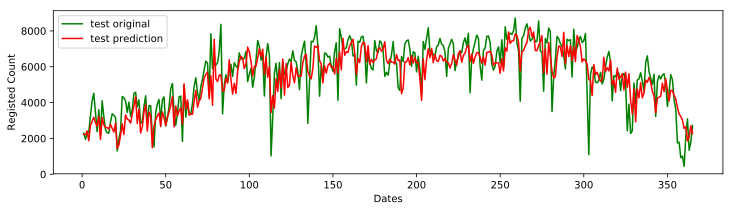

In [1820]:
time = [x + 1 for x in range(0, test.shape[0])]
plt.figure(figsize=(12,3))
plt.plot(time, test[target], color='green', label='test original')
plt.plot(time, test['xgb'], color='red', label='test prediction')
# plt.plot(time, [0 for i in range(0, result.shape[0])], '--')
plt.ylabel('Registed Count', fontsize = 10)
plt.xlabel('Dates', fontsize = 10)
plt.legend(loc='upper left')
axes = plt.gca()
# axes.set_ylim([-1,5])
plt.savefig('test_origin_vs_prediction_timeline.pdf', bbox_inches='tight')
plt.show()

In [1821]:
revenuePerBike = 3
loanCostPerBike = 2
profit = pd.DataFrame({"xgb_predict": test['xgb'], \
              target:test[target]
             })
profit['revenue_daily'] = profit.apply(lambda x: revenuePerBike * min(x[target], x['xgb_predict']), axis = 1)
profit['cost_daily'] = profit.apply(lambda x:x['xgb_predict'] * loanCostPerBike, axis = 1)
profit['profit_daily'] = profit.revenue_daily - profit.cost_daily
profit['test_lag2'] = test[lagColumnName]
profit['benchmark_profit'] = profit.apply(
    lambda x: (min(x['test_lag2'], x[target]) * revenuePerBike - loanCostPerBike * x['test_lag2']),
    axis = 1
) 
totalProfit = profit.profit_daily.sum()

# profit.to_csv("./nn_profit_regist.csv", index=False)
totalProfit

1683191.9799733162

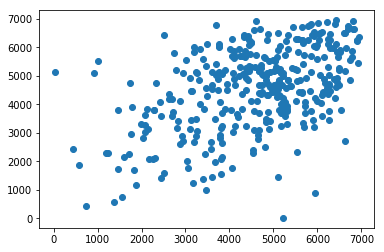

In [698]:
# baseline
from sklearn.metrics import mean_squared_error
lag2 = dataset[dataset.dteday > datetime(2011, 12, 31)]['regist_lag2']
currt = dataset[dataset.dteday > datetime(2011, 12, 31)]['registered']
mse = mean_squared_error(lag2, currt)
mse
plt.figure()
plt.scatter(dataset[dataset.dteday > datetime(2011, 12, 31)]['regist_lag2'], dataset[dataset.dteday > datetime(2011, 12, 31)]['registered'])
plt.show()

In [699]:
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'casual_lag2', 'regist_lag2',
       'avg_casual_aheadWeek', 'avg_regist_aheadWeek',
       'avg_casual_aheadMonth', 'avg_regist_aheadMonth',
       'lastWeekday_casual', 'lastWeekday_regist']

In [701]:
train = dataset[dataset.dteday < datetime(2012, 1, 1)]
test = dataset[dataset.dteday > datetime(2011, 12, 31)]
y_train_register = train.registered
y_test_register = test.registered

In [688]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train[numerical_cols])
train[numerical_cols] = scaler.transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [702]:
drop_col = ['dteday', 'yr', 'mnth', 'weekday', 'season', 'weathersit', 'cnt', 'registered']

In [703]:
train = train.drop(drop_col, axis = 1)
test = test.drop(drop_col, axis = 1)




In [704]:
train.columns.values

array(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'casual_lag2', 'regist_lag2', 'avg_casual_aheadWeek',
       'avg_regist_aheadWeek', 'avg_casual_aheadMonth',
       'avg_regist_aheadMonth', 'lastWeekday_casual',
       'lastWeekday_regist', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3'],
      dtype=object)

In [ ]:
# y_train_register = train.registered
# y_test_register = test.registered

In [726]:
clf = tree.DecisionTreeRegressor(max_depth=9)
clf = clf.fit(train_x, y_train_register[7:, ])
dt_test_predict = clf.predict(test_x)


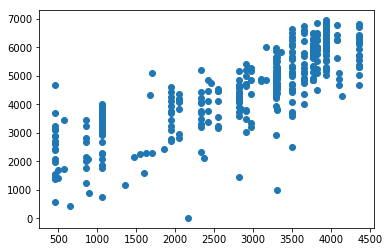

In [727]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(dt_test_predict, y_test_register)
plt.show()

In [711]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [712]:
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr = regr.fit(train_x, y_train_register[7:, ])
rf_test_prediction = regr.predict(test_x)

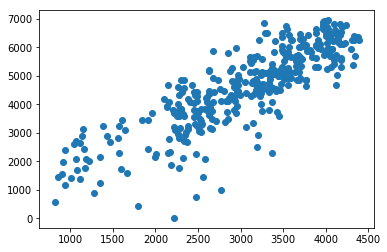

In [723]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(rf_test_prediction, y_test_register)
plt.show()

In [722]:
mse = mean_squared_error(rf_test_prediction *1.5, y_test_register)
mse**(0.5)

763.7595125868744

Feature ranking:
1. feature 7 (0.354694)
2. feature 8 (0.130683)
3. feature 10 (0.127063)
4. feature 1 (0.086496)
5. feature 3 (0.079284)
6. feature 4 (0.059502)
7. feature 16 (0.042433)
8. feature 5 (0.033951)
9. feature 2 (0.030039)
10. feature 6 (0.025759)
11. feature 9 (0.015617)
12. feature 15 (0.004990)
13. feature 14 (0.004963)
14. feature 13 (0.003287)
15. feature 0 (0.000628)
16. feature 11 (0.000321)
17. feature 12 (0.000290)


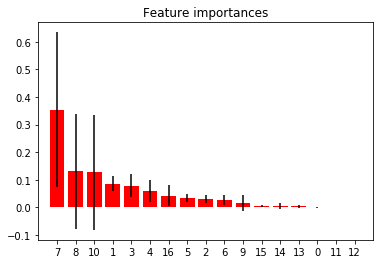

In [657]:
importances = regr.feature_importances_
importances
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(test_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(test_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(test_x.shape[1]), indices)
plt.xlim([-1, test_x.shape[1]])
plt.show()

In [658]:
test_x.columns.values

array(['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'regist_lag2', 'avg_regist_aheadWeek', 'avg_regist_aheadMonth',
       'lastWeekday_regist', 'season_1', 'season_2', 'season_3',
       'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3'],
      dtype=object)

In [ ]:
plt.figure()
plt.scatter(test, test_y)
plt.show()

In [661]:
test

,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,casual_lag2,regist_lag2,...,avg_regist_aheadMonth,lastWeekday_casual,lastWeekday_regist,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
365,0,0,-0.645691,-0.569691,0.318955,0.007115,-0.003297,-1.099850,-0.348608,-0.234642,...,-0.123076,-0.681493,-2.187347,1,0,0,0,1,0,0
366,1,0,-1.161618,-1.306540,-1.776110,1.788584,-0.798660,-1.005187,-0.036362,-0.890386,...,-0.181330,-0.454127,-1.772728,1,0,0,0,1,0,0
367,0,1,-1.816354,-2.059594,-1.372535,2.255089,-1.077576,-0.584458,0.001323,-1.092447,...,-0.251634,-1.039549,-1.609163,1,0,0,0,1,0,0
368,0,1,-2.042505,-2.101050,-1.552066,-0.089630,-1.066779,-0.463977,-0.791855,-0.998088,...,-0.322954,-0.767426,-0.669614,1,0,0,0,0,1,0
369,0,1,-1.199984,-1.150538,-0.814313,-0.798509,-0.985804,0.357400,-1.070006,-0.578717,...,-0.350574,-0.769217,-0.553597,1,0,0,0,1,0,0
370,0,1,-0.836366,-0.780940,-0.693697,-0.307192,-0.685294,0.987537,-1.059239,-0.458625,...,-0.371553,-0.344920,-0.231221,1,0,0,0,1,0,0
371,0,0,-0.521532,-0.479118,-0.763821,-0.218441,0.687696,0.662428,-0.978486,0.360102,...,-0.387741,-0.033410,-0.885482,1,0,0,0,1,0,0
372,0,0,-0.818630,-0.780993,-1.212643,-0.000982,-0.159851,0.064803,-0.678800,0.988206,...,-0.339722,0.004186,-1.087086,1,0,0,0,1,0,0
373,0,1,-1.421697,-1.335371,0.380670,-1.201282,-1.046985,-0.466845,0.690420,0.664146,...,-0.238241,-0.787119,-0.992941,1,0,0,0,0,1,0
374,0,1,-0.971902,-0.909055,0.009417,-0.052678,-0.926421,0.637567,-0.154800,0.068449,...,-0.250799,-1.064613,-0.574518,1,0,0,0,1,0,0
